In [1]:
import pandas as pd
from google.cloud import bigquery
# プロジェクトIDの指定
project_id = 'inunaki'
# authが終わっていたら普通にクライアント認証は通る
client = bigquery.Client(project=project_id)

In [2]:
query = """
CREATE TEMPORARY FUNCTION to_date() AS ("20230713");
CREATE TEMPORARY FUNCTION to_date_start_date() AS("20230619");
CREATE TEMPORARY FUNCTION eventtype() AS ('use_coupon');
CREATE TEMPORARY FUNCTION cuponname1() AS ('couponId');
CREATE TEMPORARY FUNCTION cuponname2() AS ('couponName');

WITH karte_data AS
(
SELECT FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', sync_date,  'Asia/Tokyo') AS sync_date, keys.user_id, event_name,
SUBSTR(values,instr(values,cuponname1())+LENGTH(cuponname1())+3,instr(SUBSTR(values,instr(values,cuponname1())+LENGTH(cuponname1())+3,999),",")-2)AS cupon_id,
SUBSTR(values,instr(values,cuponname2())+LENGTH(cuponname2())+3,instr(SUBSTR(values,instr(values,cuponname2())+LENGTH(cuponname2())+3,999),",")-2)AS cupon_name
FROM `karte-data.karte_stream_d2f5a0270a8665d8c5658511756d347c.krt_pockyevent_v1_*`
WHERE _TABLE_SUFFIX BETWEEN to_date_start_date() AND  to_date()
-- WHERE _TABLE_SUFFIX BETWEEN "20230601" AND "20230619"
AND event_name LIKE CONCAT('%',eventtype(),'%')
)
SELECT sync_date, user_id, event_name, karte_data.cupon_id
FROM karte_data
"""

#データフレームに変換
df_cupon_use = client.query(query).to_dataframe()

df_cupon_use["sync_date"] = pd.to_datetime(df_cupon_use["sync_date"])
df_cupon_use["salesday"] = df_cupon_use["sync_date"].dt.strftime("%Y-%m-%d")
df_cupon_use["salesday"] = pd.to_datetime(df_cupon_use["salesday"])

In [3]:
df_cupon_use.head()

,sync_date,user_id,event_name,cupon_id,salesday
0,2023-07-14 07:29:53,2970005351033,use_coupon,199,2023-07-14
1,2023-07-14 00:07:24,2970000007591,use_coupon,192,2023-07-14
2,2023-07-14 04:27:38,2970001793943,use_coupon,202,2023-07-14
3,2023-07-14 04:27:55,2970001793943,use_coupon,201,2023-07-14
4,2023-07-14 04:25:44,2970001793943,use_coupon,203,2023-07-14


In [4]:
query = """
SELECT DISTINCT coupon_id, coupon_name
FROM `inunaki.dwd_action_0001.dwd_karte_user_use_coupon` 
WHERE DATE(year, month, dt) BETWEEN "2023-06-14" AND "2023-07-13"
"""
df_coupon_id = client.query(query).to_dataframe()

In [5]:
df_coupon_id.head()

,coupon_id,coupon_name
0,168,SWIM_GOGGLES
1,155,新ギョーザ
2,156,本格炒め炒飯
3,151,TRIAL農園バナナ
4,177,マヨネーズ_500g


In [6]:
df_coupon_id.coupon_name.unique()

array(['SWIM_GOGGLES', '新ギョーザ', '本格炒め炒飯', 'TRIAL農園バナナ', 'マヨネーズ_500g',
       'たこ焼き_40個入', 'ミニハンバーグ', '讃岐うどん細麺', '5層のチョコケーキ', 'ばら印の上白糖_1kg',
       'TRIALミックスサラダ', 'キャノーラ油\u30001000g', 'キャノーラ油\u30001500g',
       'なめらかティラミス', '栗を味わうモンブラン', 'えびとチーズのグラタン', 'クイックゴーグル_一般用',
       'キユーピー_マヨネーズ_450g', 'チーズチーズチーズケーキ', '桜島どりジャンボチキンカツ',
       'クイックゴーグル_ジュニア用', 'アルフォートファミリーサイズ', '２段仕込旨み醤油から揚げ\u3000中',
       'ひんやり敷きパッド_S_約100×205cm', 'トライアルブレッドレーズン_6枚切り',
       'ミラータイプゴーグル一般用ブラック', 'コンパクトボックスティッシュ_150枚×5',
       'もっちりひんやり敷きパッド_S_約100×205cm', 'キッチンタオル_4ロール×180カット_3.6倍巻き',
       'フリーザーバッグ増量タイプお徳用_L_25枚入り', 'フリーザーバッグ増量タイプお徳用_M_50枚入り',
       '美味しさだけにこだわったプリン（なめらか）', '【テスト】サッポロレモンキャンペーン',
       '【テスト】ひんやり敷きパッド_S_約100×205cm', '【テスト】2023春_実質0円（タダ）になるかも?キャンペーン',
       'プチシリーズ_各種', '黄金の味(甘口/中辛/辛口)_480ml', '堅あげポテト_[うすしお/ブラックペッパー]',
       'システマハブラシ_各種（セット売り商品は対象外）', 'ジャワカレールウ_各種',
       'オーマイ_早ゆで結束スパゲッティ_600g_[1.6mm/1.8mm]', 'シーバ_パウチ_[35g/40g]×6袋_各種'],
      dtype=object)

In [7]:
len(df_coupon_id)

42

In [8]:
# クーポン情報を追加する
query = """
SELECT *
FROM `inunaki.dst_workspace.su-pay_coupon_list6m`
"""
#データフレームに変換
df_cupon = client.query(query).to_dataframe()

df_cupon["cupon_id"] = df_cupon["cupon_id"].astype(str)

# クーポン名を追加する
df_cupon_use = df_cupon_use.merge(df_coupon_id.rename(columns={"coupon_id":"cupon_id"}),on="cupon_id",how="left")

In [9]:
df_cupon_use.coupon_name.nunique()

42

In [10]:
# あとで使うように残しておく
df_cupon_sengen = df_cupon_use.copy()

In [11]:
df_cupon_use.head()

,sync_date,user_id,event_name,cupon_id,salesday,coupon_name
0,2023-07-14 07:29:53,2970005351033,use_coupon,199,2023-07-14,NaN
1,2023-07-14 00:07:24,2970000007591,use_coupon,192,2023-07-14,NaN
2,2023-07-14 04:27:38,2970001793943,use_coupon,202,2023-07-14,黄金の味(甘口/中辛/辛口)_480ml
3,2023-07-14 04:27:55,2970001793943,use_coupon,201,2023-07-14,ジャワカレールウ_各種
4,2023-07-14 04:25:44,2970001793943,use_coupon,203,2023-07-14,NaN


In [12]:
query = """
WITH base AS(
  SELECT  salesday, COALESCE(customercd_new, posid.customercd) AS customercd, jan, SUM(salesamount)AS sales_amt, SUM(salescnt)AS cnt
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  WHERE salesday BETWEEN "2023-06-19" AND "2023-07-13"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND jan IN(
  '00000004580575373410',
 '00000004580575373427',
 '00000006970747941048',
 '00000006970747941178',
 '00000004522646757071',
 '00000004522646757088',
 '00000004522646757125',
 '00000004522646757132',
 '00000004522646757149',
 '00000004522646757156',
 '00000004522646757163',
 '00000004522646757170',
 '00000004522646882407',
 '00000004522646911459',
 '00000004522646940381',
 '00000004902410113058',
 '00000004903380253430',
 '00000004903380254956',
 '00000004522646331684',
 '00000004522646331691',
 '00000004522646390612',
 '00000002529579000000',
 '00000002556230000000',
 '00000004528594090000',
 '00000004580495200568',
 '00000004522646860351',
 '00000004522646860436',
 '00000004901360347988',
 '00000004901577042072',
 '00000004902930040001',
 '00000004522646813791',
 '00000004571256310336',
 '00000004901001397457',
 '00000004902130344916',
 '00000004902130390418',
 '00000004902165000269')
  AND posid.customercd <> "0"
  GROUP BY salesday, customercd, jan
 )
 SELECT　salesday, md5cus.customercd, base.jan, sales_amt, cnt, janname
 FROM base
LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5cus
ON base.customercd = md5cus.customercd_md5
JOIN `inunaki.dim_common_0001.dim_product` a
ON a.jan = base.jan
"""
#データフレームに変換
df_jan = client.query(query).to_dataframe()

df_jan["jan2"] = df_jan["jan"].astype(int)
df_jan["customercd2"] = df_jan["customercd"].astype(int)
df_jan["salesday"] = pd.to_datetime(df_jan["salesday"])

In [13]:
## クーポンを利用した人
query = """
CREATE TEMPORARY FUNCTION to_date() AS ("20230713");
CREATE TEMPORARY FUNCTION to_date_start_date() AS("20230619");
CREATE TEMPORARY FUNCTION eventtype() AS ('view');
CREATE TEMPORARY FUNCTION viewname() AS ('CouponList');

WITH karte_data AS
(
SELECT FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', sync_date,  'Asia/Tokyo') AS sync_date,keys.user_id,event_name,view.title
FROM `karte-data.karte_stream_d2f5a0270a8665d8c5658511756d347c.krt_pockyevent_v1_*`
WHERE _TABLE_SUFFIX BETWEEN to_date_start_date() AND to_date()
AND event_name LIKE CONCAT('%', eventtype() ,'%') AND view.view_name LIKE CONCAT('%', viewname(),'%')
)
SELECT * 
FROM karte_data
"""


df_c_view = client.query(query).to_dataframe()

df_c_view["sync_date"] = pd.to_datetime(df_c_view["sync_date"])
df_c_view["salesday"] = df_c_view["sync_date"].dt.strftime("%Y-%m-%d")
df_c_view["salesday"] = pd.to_datetime(df_c_view["salesday"])

# 対象IDだけにする
df_taisho = pd.read_csv("data/アプリクーポン6月対象者.csv").rename(columns={"顧客ID":"user_id"})
df_taisho["user_id"] = df_taisho["user_id"].astype(str)

df_taisho2 = pd.read_csv("data/対象ID/6-7月クーポン対象ID.csv").rename(columns={"6-7CouponID":"user_id"})
df_taisho2["user_id"] = df_taisho2["user_id"].astype(str)

In [14]:
df_c_view2 = df_c_view.copy()
# マージする
df_c_view = df_c_view.merge(df_taisho2,on="user_id")

In [15]:
# ホームを見た人
query = """
SELECT sync_dttm, DATE(year, month, dt) AS dt, customercd, view_name
FROM `inunaki.dwd_action_0001.dwd_karte_supay_accesshome` view_data 
JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
ON view_data.customer_id = md5_cus.customercd_md5
WHERE DATE(year, month, dt) BETWEEN "2023-06-19" AND "2023-07-13"
"""

df_home_view = client.query(query).to_dataframe()
df_home_view["salesday"] = pd.to_datetime(df_home_view["dt"])
# df_home_view["salesday"] = df_home_view["sync_date"].dt.strftime("%Y-%m-%d")
df_home_view["salesday"] = pd.to_datetime(df_home_view["salesday"])
df_home_view = df_home_view.rename(columns={"customercd":"user_id"})

df_home_view = df_home_view.merge(df_taisho2,on="user_id")

In [16]:
df_home_view.head()

,sync_dttm,dt,user_id,view_name,salesday
0,2023-06-19 06:10:28.959,2023-06-19,2970000796907,Home,2023-06-19
1,2023-06-19 07:21:58.692,2023-06-19,2970000796907,Home,2023-06-19
2,2023-06-19 06:10:23.588,2023-06-19,2970000796907,Home,2023-06-19
3,2023-06-19 07:01:24.571,2023-06-19,2970000796907,Home,2023-06-19
4,2023-06-19 07:15:32.024,2023-06-19,2970000796907,Home,2023-06-19


In [17]:
# query = """
# SELECT *
# FROM `inunaki.dst_workspace.app_cupon_jan`
# WHERE haisin_tuki = "2023-06-01"
# """
# #データフレームに変換
# df_taisho_id = client.query(query).to_dataframe()
# df_taisho_id["jan"] = df_taisho_id["jan"].astype(str)
df_taisho_id = pd.read_csv("data/六月のjan_クーポン.csv")
df_taisho_id["jan"] = df_taisho_id["jan"].astype(str)

In [18]:
list_jan = [df_taisho_id["jan"][i].zfill(20) for i in range(0,len(df_taisho_id))]

In [19]:
# 対象のクーポンについてだけ示す
tmp = df_taisho_id.query("kubun=='時短主婦向けクーポン'").reset_index()
[tmp["jan"][i].zfill(20) for i in range(0,len(tmp))]

['00000004522646813791',
 '00000004571256310336',
 '00000004901001397457',
 '00000004902130344916',
 '00000004902130390418',
 '00000004902165000269']

In [20]:
tmp = df_taisho_id.query("kubun=='生鮮クーポン'").reset_index()
[tmp["jan"][i].zfill(20) for i in range(0,len(tmp))]

['00000002529579000000',
 '00000002556230000000',
 '00000004528594090000',
 '00000004580495200568']

In [21]:
# 名前を変更するのとクーポンIDを数値に変換する
df_cupon_use["coupon_id"] = df_cupon_use["cupon_id"].astype(int)

In [22]:
# janをつける ## coupon_name
df_cupon_use = df_cupon_use.merge(df_taisho_id[["coupon_id","jan"]],on="coupon_id",how="left")

In [23]:
# df_taisho_id.to_csv("六月のjan_クーポン.csv",index=False, encoding="utf_8_sig")
# df_coupon_id.to_csv("六月のクーポンID.csv",index=False, encoding="utf_8_sig")

In [24]:
df_cupon_use[df_cupon_use["jan"].isnull()].sort_values("jan")

df_cupon_use = df_cupon_use.dropna()

df_cupon_use["jan2"] = df_cupon_use["jan"].astype(int)
df_cupon_use["customercd2"] = df_cupon_use["user_id"].astype(int)

In [25]:
# 6月の結果 df_cupon_use
df_date2 = pd.DataFrame()
for i in df_cupon_use.query("salesday<=20230630")["user_id"].unique():
    # 日付を作る
    df_date = pd.DataFrame({"salesday":pd.date_range(start="2023-06-19",end="2023-07-13")})
    df_date["a"] = 1
    # クーポン対象商品を出す
    df_a = df_cupon_use.query("user_id==@i").reset_index().drop("index",axis=1)[["salesday","coupon_name","jan2","user_id"]]\
    .rename(columns={"salesday":"start_date"})
    df_a["a"] = 1
    # 日毎に作る
    df_date = df_date.merge(df_a,on="a")
    del df_date["a"]
    df_date["flg"] = df_date.apply(lambda x:1 if x["start_date"]<=x["salesday"] else 0, axis=1)
    df_date = df_date.query("flg==1")
    df_date2 = pd.concat([df_date2,df_date])

df_result_6m = df_jan.merge(df_date2.rename(columns={"user_id":"customercd"}),on=["salesday","customercd","jan2"])

In [26]:
# 重複がないかは確認
df_result = df_result_6m.groupby(["customercd2","coupon_name"]).head(1)

In [27]:
# 重複を削除
df_cupon_use = df_cupon_use.groupby(["coupon_name","user_id"]).head(1)

In [28]:
# 日ごとの購入者
df_tmp = df_result.groupby(["salesday"]).agg({"flg":"sum","customercd":"nunique"}).reset_index().rename(columns={"flg":"クーポン利用人数","customercd":"クーポン利用人数UU"})

# 宣言人数
df_tmp2 = df_cupon_use.groupby(["salesday"]).agg({"sync_date":"count","user_id":"nunique"}).reset_index().rename(columns={"sync_date":"宣言人数","user_id":"宣言人数UU"})

# クーポンタブ表示人数
df_tmp3 = df_c_view.groupby(["salesday"]).agg({"sync_date":"count","user_id":"nunique"}).reset_index().rename(columns={"sync_date":"クーポンタブ閲覧人数","user_id":"クーポンタブ閲覧UU"})

In [29]:
# 累積宣言UU
df_tmp4 = df_cupon_use.sort_values("salesday").groupby(["user_id"]).head(1).groupby(["salesday"]).agg({"user_id":"count"}).reset_index().rename(columns={"user_id":"累積宣言UU"})
df_tmp4["累積宣言UU"]= df_tmp4["累積宣言UU"].cumsum()
# 累積クーポンタブUU
df_tmp5 = df_c_view.query("salesday>=20230619").sort_values("salesday").groupby(["user_id"]).head(1).groupby(["salesday"]).agg({"user_id":"count"}).reset_index().rename(columns={"user_id":"累積クーポン閲覧UU"})
df_tmp5["累積クーポン閲覧UU"]= df_tmp5["累積クーポン閲覧UU"].cumsum()
# 累積購入クーポンUU
df_tmp6 = df_result.sort_values("salesday").groupby(["customercd"]).head(1).groupby(["salesday"]).agg({"customercd":"count"}).reset_index().rename(columns={"customercd":"累積クーポン利用UU"})
df_tmp6["累積クーポン利用UU"]= df_tmp6["累積クーポン利用UU"].cumsum()

In [30]:
# 結果を表示
df_result2 = df_tmp3.merge(df_tmp2,on="salesday").merge(df_tmp,on="salesday")
df_result2 = df_result2.merge(df_tmp4, on="salesday")
df_result2 = df_result2.merge(df_tmp5, on="salesday")
df_result2 = df_result2.merge(df_tmp6, on="salesday")
df_result2 = df_result2.rename(columns={"salesday":"日付"})

In [31]:
# 対少人数（力ずく）
df_result2["対象UU"] = 15833

In [32]:
# クーポン利用率
df_result2["クーポン利用率"] = round((df_result2["クーポン利用人数UU"] / df_result2["対象UU"]) * 100, 1)
df_result2["クーポン利用率"] = df_result2["クーポン利用率"].astype(str) + '%'

# タブ閲覧率
df_result2["タブ閲覧率"] = round((df_result2["クーポンタブ閲覧UU"] / df_result2["対象UU"]) * 100, 1)
df_result2["タブ閲覧率"] = df_result2["タブ閲覧率"].astype(str) + '%'

# 宣言率
df_result2["宣言率"] = round((df_result2["宣言人数UU"] / df_result2["対象UU"]) * 100, 1)
df_result2["宣言率"] = df_result2["宣言率"].astype(str) + '%'

In [33]:
df_result2 = df_result2[["日付","対象UU","クーポンタブ閲覧人数","クーポンタブ閲覧UU","累積クーポン閲覧UU",
            "タブ閲覧率","宣言人数","宣言人数UU","累積宣言UU","宣言率","クーポン利用人数","クーポン利用人数UU","累積クーポン利用UU","クーポン利用率"]]

In [34]:
df_result2

,日付,対象UU,クーポンタブ閲覧人数,クーポンタブ閲覧UU,累積クーポン閲覧UU,タブ閲覧率,宣言人数,宣言人数UU,累積宣言UU,宣言率,クーポン利用人数,クーポン利用人数UU,累積クーポン利用UU,クーポン利用率
0,2023-06-19,15833,2409,1134,1134,7.2%,430,115,115,0.7%,21,15,15,0.1%
1,2023-06-20,15833,935,451,1494,2.8%,95,48,162,0.3%,20,15,30,0.1%
2,2023-06-21,15833,689,363,1744,2.3%,56,28,190,0.2%,13,11,41,0.1%
3,2023-06-22,15833,675,381,1998,2.4%,70,33,222,0.2%,14,12,53,0.1%
4,2023-06-23,15833,668,359,2235,2.3%,85,30,247,0.2%,15,12,64,0.1%
5,2023-06-24,15833,793,443,2522,2.8%,67,41,284,0.3%,33,26,87,0.2%
6,2023-06-25,15833,705,385,2751,2.4%,95,40,323,0.3%,25,21,107,0.1%
7,2023-06-26,15833,641,359,2952,2.3%,97,27,343,0.2%,21,15,120,0.1%
8,2023-06-27,15833,540,305,3114,1.9%,44,25,366,0.2%,10,10,129,0.1%
9,2023-06-28,15833,511,262,3238,1.7%,29,22,385,0.1%,14,14,143,0.1%


In [35]:
# query = """
# SELECT md5cus.customercd, age, sex
# FROM(
# SELECT COALESCE(customercd_new, cus_info.customercd) AS customercd, age, sex
# FROM `inunaki.dim_common_0001.dim_crm_customer_info` cus_info
# LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
# ON cus_info.customercd = ii.customercd
# ) base
# LEFT JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5cus
# ON base.customercd = md5cus.customercd_md5
# """
# #データフレームに変換
# df_age = client.query(query).to_dataframe()

In [36]:
# df_age.head()

In [37]:
# df_view_tmp = df_c_view[["salesday","user_id"]].drop_duplicates()
# df_view_tmp = df_view_tmp.merge(df_age.rename(columns={"customercd":"user_id"}),on="user_id")

In [38]:
# df_tmp = pd.pivot_table(df_view_tmp,index="salesday",columns="age",aggfunc="count",values="user_id").fillna(0)

In [39]:
# df_tmp[[20,25,30,35,40,45,50,55,60,65,70,75]].style.background_gradient(axis=1)

## 効果検証

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

!pip install --q japanize_matplotlib
import japanize_matplotlib

%matplotlib inline
plt.style.use("ggplot")

In [41]:
### 企画ごとの対象者を出す。

# import os
import glob
# directory = "/home/jupyter/su-pay/data/対象ID/"
file_list = glob.glob("/home/jupyter/su-pay/data/対象ID/*.csv")

# 企画ごとの対象IDを抽出する
df_kikakubetu_id = pd.DataFrame()
for i in file_list:
    df_tmp = pd.read_csv(i,header=None).rename(columns={0:"user_id"})
    df_tmp["file"] = i[31:-8]
    df_kikakubetu_id = pd.concat([df_kikakubetu_id, df_tmp])

df_kikakubetu_id = df_kikakubetu_id.query("user_id!='2306CouponID'")
df_kikakubetu_id = df_kikakubetu_id.query("user_id!='6-7CouponID'")

In [42]:
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='フローズンクーポン', "kubun"] = "時短主婦向けクーポン"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='PB生活クーポン', "kubun"] = "PB_生活"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='PBデイリークーポン', "kubun"] = "PB_デイリー"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='生鮮クーポン', "kubun"] = "生鮮クーポン"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='PBライフスタイルクーポン', "kubun"] = "PB_ライフスタイル"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='PBグロサリークーポン', "kubun"] = "PB_グロサリー"
df_kikakubetu_id.loc[df_kikakubetu_id["file"]=='PBハードクーポン', "kubun"] = "PB_ハード"

In [43]:
# 次のコードを実現するために型を変換
df_taisho_id["jan2"] = df_taisho_id["jan"].astype(int)

In [44]:
# 間口とかの情報を入れる
df_cupon_base = df_result.merge(df_taisho_id[["jan2","kubun","taisho_uu"]].drop_duplicates(),on="jan2")
df_cupon_base = df_cupon_base.drop(["jan2","customercd2"],axis=1)

In [45]:
df_taisho_id
# df_result[df_result["coupon_name"].isnull()]
df_result["coupon_name"].unique()

array(['なめらかティラミス', 'ひんやり敷きパッド_S_約100×205cm', '5層のチョコケーキ',
       'もっちりひんやり敷きパッド_S_約100×205cm', 'クイックゴーグル_一般用',
       'フリーザーバッグ増量タイプお徳用_L_25枚入り', '栗を味わうモンブラン', '桜島どりジャンボチキンカツ',
       '２段仕込旨み醤油から揚げ\u3000中', 'キャノーラ油\u30001000g', '讃岐うどん細麺',
       '美味しさだけにこだわったプリン（なめらか）', 'TRIAL農園バナナ', 'たこ焼き_40個入', 'TRIALミックスサラダ',
       'フリーザーバッグ増量タイプお徳用_M_50枚入り', '新ギョーザ', 'アルフォートファミリーサイズ',
       'キユーピー_マヨネーズ_450g', '本格炒め炒飯', 'ミニハンバーグ', 'えびとチーズのグラタン',
       'トライアルブレッドレーズン_6枚切り', 'ばら印の上白糖_1kg', 'コンパクトボックスティッシュ_150枚×5',
       'キッチンタオル_4ロール×180カット_3.6倍巻き'], dtype=object)

In [46]:
# df_cupon_sengen = 
# a = df_cupon_sengen.merge(df_taisho_id[["coupon_name","kubun"]].drop_duplicates(),on="coupon_name",how="left")

In [47]:
df_taisho_id[["jan","kubun"]].drop_duplicates()["kubun"].value_counts()

PB_ハード        7
PB_デイリー       6
時短主婦向けクーポン    6
PB_生活         4
生鮮クーポン        4
PB_グロサリー      3
間口獲得クーポン      3
PB_ライフスタイル    2
Name: kubun, dtype: int64

In [48]:
# 購入まで至ったかどうかを間口まで見る
df_ma = df_cupon_base.query("kubun=='間口獲得クーポン'")

In [49]:
df_tmp = df_ma.groupby(["customercd"]).agg({"salesday":"count"}).reset_index().rename(columns={"salesday":"cupon_count"})
df_tmp = df_tmp.groupby(["cupon_count"]).agg({"customercd":"count"}).reset_index()

<BarContainer object of 3 artists>

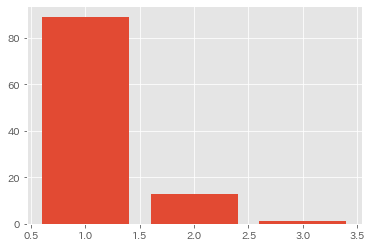

In [50]:
plt.bar(df_tmp["cupon_count"],df_tmp["customercd"])

In [51]:
df_tmp

,cupon_count,customercd
0,1,89
1,2,13
2,3,1


In [52]:
df_taisho["user_id"].nunique()

16469

In [53]:
df_c_view["user_id"].nunique()

5700

In [54]:
df_c_view = df_c_view.query("salesday<=20230713")
df_cupon_sengen = df_cupon_sengen.query("salesday<=20230713")
df_cupon_sengen = df_cupon_sengen.rename(columns={"cupon_id":"coupon_id"})
df_cupon_sengen["coupon_id"] = df_cupon_sengen["coupon_id"].astype(int)

# 宣言データに区分を追加する
df_cupon_sengen = df_cupon_sengen.merge(df_taisho_id[["coupon_id","kubun"]].drop_duplicates(),on="coupon_id")

# 間口のみに絞る
df_sengen_ma = df_cupon_sengen.query("kubun=='間口獲得クーポン'")

In [55]:
df_taisho_id.query("kubun=='時短主婦向けクーポン'")

,coupon_id,cupon_name,jan,kubun,haisin_tuki,end_tuki,huyo_point,taisho_uu,coupon_name,types,jan2
31,153,讃岐うどん細麺,4522646813791,時短主婦向けクーポン,2023/6/1,2023/6/30,10,6706,讃岐うどん細麺,一回限り,4522646813791
32,154,たこ焼き 40個入,4571256310336,時短主婦向けクーポン,2023/6/1,2023/6/30,25,6706,たこ焼き_40個入,一回限り,4571256310336
33,155,新ギョーザ,4901001397457,時短主婦向けクーポン,2023/6/1,2023/6/30,15,6706,新ギョーザ,一回限り,4901001397457
34,156,本格炒め炒飯,4902130344916,時短主婦向けクーポン,2023/6/1,2023/6/30,15,6706,本格炒め炒飯,一回限り,4902130344916
35,157,ミニハンバーグ,4902130390418,時短主婦向けクーポン,2023/6/1,2023/6/30,10,6706,ミニハンバーグ,一回限り,4902130390418
36,158,えびとチーズのグラタン,4902165000269,時短主婦向けクーポン,2023/6/1,2023/6/30,10,6706,えびとチーズのグラタン,一回限り,4902165000269


In [56]:
## 変換しておく
df_home_view["user_id"] = df_home_view["user_id"].astype(int)
df_kikakubetu_id["user_id"] = df_kikakubetu_id["user_id"].astype(int)
df_c_view["user_id"] = df_c_view["user_id"].astype(int)

In [57]:
# 全体（間口）のみ集計
df_kikakubetu_result = pd.DataFrame({"対象企画":["間口獲得クーポン"],
              "対象ID":[df_kikakubetu_id.query("file=='6-7月クーポン'")["user_id"].nunique()],
              "アクティブユーザー":[df_home_view["user_id"].nunique()],
              "クーポンタブ閲覧UU":[df_c_view["user_id"].nunique()],
              "クーポン宣言UU":[df_sengen_ma["user_id"].nunique()],
             "クーポン利用UU":df_ma["customercd"].nunique()})


# 全体以外の企画の結果も出す
for i in df_cupon_base.query("kubun!='間口獲得クーポン'")["kubun"].unique():
    # 対象IDだけに絞る
    df_home_view_tmp = df_home_view.merge(df_kikakubetu_id.query("kubun==@i"),on="user_id")
    df_c_view_tmp = df_c_view.merge(df_kikakubetu_id.query("kubun==@i"),on="user_id")
    
    df_tmp = pd.DataFrame({"対象企画":[i],
              # "対象ID":[df_taisho["user_id"].nunique()],
              "対象ID":[df_kikakubetu_id.query("kubun==@i")["user_id"].nunique()],
              "アクティブユーザー":[df_home_view_tmp["user_id"].nunique()],
              "クーポンタブ閲覧UU":[df_c_view_tmp["user_id"].nunique()],
              "クーポン宣言UU":[df_cupon_sengen.query("kubun==@i")["user_id"].nunique()],
             "クーポン利用UU":df_cupon_base.query("kubun==@i")["customercd"].nunique()})
    df_kikakubetu_result = pd.concat([df_kikakubetu_result, df_tmp])


# 比率を出す
df_kikakubetu_result["クーポンタブ閲覧率"] = round(df_kikakubetu_result["クーポンタブ閲覧UU"] / df_kikakubetu_result["アクティブユーザー"] * 100, 2)
df_kikakubetu_result["クーポン宣言率"] = round(df_kikakubetu_result["クーポン宣言UU"] / df_kikakubetu_result["アクティブユーザー"] * 100, 2)
df_kikakubetu_result["クーポン利用率"] = round(df_kikakubetu_result["クーポン利用UU"] / df_kikakubetu_result["アクティブユーザー"] * 100, 2)
df_kikakubetu_result["閲覧から宣言まで"] = round(df_kikakubetu_result["クーポン宣言UU"] / df_kikakubetu_result["クーポンタブ閲覧UU"] * 100, 2)
df_kikakubetu_result["閲覧から宣言までの離脱率"] = 100 - df_kikakubetu_result["閲覧から宣言まで"]

df_kikakubetu_result["クーポンタブ閲覧率"] = df_kikakubetu_result["クーポンタブ閲覧率"].astype(str) + "%"
df_kikakubetu_result["クーポン宣言率"] = df_kikakubetu_result["クーポン宣言率"].astype(str) + "%"
df_kikakubetu_result["クーポン利用率"] = df_kikakubetu_result["クーポン利用率"].astype(str) + "%"
df_kikakubetu_result["閲覧から宣言まで"] = df_kikakubetu_result["閲覧から宣言まで"].astype(str) + "%"
df_kikakubetu_result["閲覧から宣言までの離脱率"] = df_kikakubetu_result["閲覧から宣言までの離脱率"].astype(str) + "%"

df_kikakubetu_result = df_kikakubetu_result.reset_index().drop("index",axis=1)

In [58]:
df_kikakubetu_result.sort_values("対象ID",ascending=False)

,対象企画,対象ID,アクティブユーザー,クーポンタブ閲覧UU,クーポン宣言UU,クーポン利用UU,クーポンタブ閲覧率,クーポン宣言率,クーポン利用率,閲覧から宣言まで,閲覧から宣言までの離脱率
0,間口獲得クーポン,15849,13949,5673,421,103,40.67%,3.02%,0.74%,7.42%,92.58%
5,生鮮クーポン,12488,10689,4093,367,105,38.29%,3.43%,0.98%,8.97%,91.03%
7,時短主婦向けクーポン,4085,3565,1421,105,21,39.86%,2.95%,0.59%,7.39%,92.61%
3,PB_ハード,2891,2807,1360,25,2,48.45%,0.89%,0.07%,1.84%,98.16%
2,PB_ライフスタイル,2859,2777,1346,49,2,48.47%,1.76%,0.07%,3.64%,96.36%
1,PB_デイリー,2559,2483,1194,62,11,48.09%,2.5%,0.44%,5.19%,94.81%
4,PB_生活,2352,2282,1106,88,13,48.47%,3.86%,0.57%,7.96%,92.04%
6,PB_グロサリー,1694,1631,780,56,7,47.82%,3.43%,0.43%,7.18%,92.82%


In [59]:
df_kikakubetu_result.query("対象企画=='PB_ライフスタイル'|対象企画=='PB_デイリー'|対象企画=='PB_ハード'|対象企画=='PB_生活'|対象企画=='PB_グロサリー'")

,対象企画,対象ID,アクティブユーザー,クーポンタブ閲覧UU,クーポン宣言UU,クーポン利用UU,クーポンタブ閲覧率,クーポン宣言率,クーポン利用率,閲覧から宣言まで,閲覧から宣言までの離脱率
1,PB_デイリー,2559,2483,1194,62,11,48.09%,2.5%,0.44%,5.19%,94.81%
2,PB_ライフスタイル,2859,2777,1346,49,2,48.47%,1.76%,0.07%,3.64%,96.36%
3,PB_ハード,2891,2807,1360,25,2,48.45%,0.89%,0.07%,1.84%,98.16%
4,PB_生活,2352,2282,1106,88,13,48.47%,3.86%,0.57%,7.96%,92.04%
6,PB_グロサリー,1694,1631,780,56,7,47.82%,3.43%,0.43%,7.18%,92.82%


In [60]:
df_tmp = df_cupon_sengen.groupby(["coupon_name"]).agg({"user_id":"count"}).rename(columns={"user_id":"宣言数"}).reset_index()
df_tmp2 = df_cupon_base.groupby(["coupon_name"]).agg({"flg":"count"}).rename(columns={"flg":"クーポン利用数"}).reset_index()
df_item_jiku = df_tmp.merge(df_tmp2,on="coupon_name",how="outer")
df_item_jiku["宣言利用率"] = round(df_item_jiku["クーポン利用数"] / df_item_jiku["宣言数"], 4)
df_item_jiku = df_item_jiku.merge(df_taisho_id[["coupon_name","kubun"]].drop_duplicates(),on="coupon_name",how="right").fillna(0)
df_item_jiku = df_item_jiku[["coupon_name","kubun","宣言数","クーポン利用数","宣言利用率"]].sort_values("クーポン利用数",ascending=False)

df_item_jiku.reset_index().drop("index",axis=1).rename(columns={"coupon_name":"クーポン名","kubun":"区分"}).to_csv("6月のクーポン結果.csv",encoding="utf_8_sig")
df_item_jiku.reset_index().drop("index",axis=1).rename(columns={"coupon_name":"クーポン名","kubun":"区分"})

In [62]:
df_cupon_sengen["coupon_name"].nunique()

32

In [63]:
df_rank = pd.read_csv("data/アプリクーポン6月対象者.csv")[["顧客ID","カテゴリ"]].rename(columns={"顧客ID":"user_id","カテゴリ":"ランク"})

In [64]:
df_cupon_sengen["user_id"] = df_cupon_sengen["user_id"].astype(int)

In [65]:
a = df_cupon_sengen.merge(df_rank,on="user_id").groupby(["ランク"]).agg({"user_id":"count"}).rename(columns={"user_id":"宣言人数"})
ab = df_rank.groupby(["ランク"]).agg({"user_id":"count"}).rename(columns={"user_id":"全体数"})
a = a.merge(ab,on="ランク")
a["比率"] = round(a["宣言人数"] / a["全体数"], 3)
a.reindex(index=["H","M","L","E"])

,宣言人数,全体数,比率
ランク,,,
H,279,874,0.319
M,698,2182,0.320
L,419,3079,0.136
E,598,10334,0.058


### 時短クーポン

直近3ヶ月の購買を参考にする。

対象商品を買っていないかどうかで判断

In [66]:
# 時短クーポンの結果について（対象外）
query = """
-- 時短主婦向けクーポン（30代〜50代）
-- 対象期間全体の顧客
WITH base AS(
  SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` cus_info
  ON posid.customercd = cus_info.customercd
  WHERE salesday BETWEEN "2023-03-19" AND "2023-06-18"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND posid.customercd <> "0"
  AND age BETWEEN 30 AND 59
 ),
 -- 期間前に買っていないかどうかを確認する
 taisho_data AS(
  SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd, 1 AS flg
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` cus_info
  ON posid.customercd = cus_info.customercd
  WHERE salesday BETWEEN "2023-03-19" AND "2023-06-18"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND jan IN(
 '00000004522646813791',
 '00000004571256310336',
 '00000004901001397457',
 '00000004902130344916',
 '00000004902130390418',
 '00000004902165000269')
  AND posid.customercd <> "0"
  AND age BETWEEN 30 AND 59
 ),


 -- 期間中に対象の商品を買っていない人たち（これが全体になる）
taisho_id AS(
  SELECT base.customercd, COALESCE(flg, 0) AS flg
  FROM base
  LEFT JOIN taisho_data
  ON base.customercd = taisho_data.customercd
  WHERE  COALESCE(flg, 0) = 0
),
-- 期間中に対象の商品を買った人
result AS(
  SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd, 1 AS kounyu_flg 
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` cus_info
  ON posid.customercd = cus_info.customercd
  -- 対象になっている顧客のみに絞る
  JOIN taisho_id
  ON posid.customercd = taisho_id.customercd
  WHERE salesday BETWEEN "2023-06-19" AND "2023-07-13"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND jan IN(
 '00000004522646813791',
 '00000004571256310336',
 '00000004901001397457',
 '00000004902130344916',
 '00000004902130390418',
 '00000004902165000269')
)
-- 購入したかしていないかを見る
SELECT md5_cus.customercd, COALESCE(kounyu_flg, 0) AS kounyu_flg
FROM taisho_id
LEFT JOIN result
ON taisho_id.customercd = result.customercd
JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
ON taisho_id.customercd = md5_cus.customercd_md5

"""
df_taishogai_jitan = client.query(query).to_dataframe()

In [67]:
df_taishogai_jitan["customercd"] = df_taishogai_jitan["customercd"].astype(int)
# 対象の顧客は外す
df_taishogai_jitan = df_taishogai_jitan.merge(df_kikakubetu_id.rename(columns={"user_id":"customercd"}).query("kubun=='時短主婦向けクーポン'"),on="customercd",how="left").fillna(0)
df_taishogai_jitan = df_taishogai_jitan.query("kubun==0")

In [68]:
df_taishogai_jitan["kubun"].unique()

array([0], dtype=object)

In [69]:
print("時短商品を対象外の同じ条件の人が期間中買った割合")
print(round(df_taishogai_jitan["kounyu_flg"].sum() / len(df_taishogai_jitan)*100,1),"%")

時短商品を対象外の同じ条件の人が期間中買った割合
1.8 %


In [70]:
# 対象外の人と比べるとどれくらい使われているか？
df_yes_coupon = df_kikakubetu_result.query("対象企画=='時短主婦向けクーポン'")[["対象ID","クーポン利用UU","クーポン利用率"]]
df_yes_coupon = df_yes_coupon.rename(columns={"クーポン利用UU":"利用人数","クーポン利用率":"利用率"})
df_yes_coupon["区分"] = "対象"

df_no_coupon = pd.DataFrame({"区分":["対象外"],"対象ID":[df_taishogai_jitan["customercd"].nunique()],"利用人数":[df_taishogai_jitan["kounyu_flg"].sum()]})
df_no_coupon["利用率"] = round(df_no_coupon["利用人数"] / df_no_coupon["対象ID"] * 100,1)
df_no_coupon["利用率"] = df_no_coupon["利用率"].astype(str) + "%"

In [71]:
df_jitan_result = pd.concat([df_no_coupon,df_yes_coupon])
df_jitan_result.reindex(index=[7,0]).rename(columns={"利用人数":"購入人数","利用率":"購入率"})

,区分,対象ID,購入人数,購入率
7,対象,4085,21,0.59%
0,対象外,82712,1494,1.8%


### PB商品の全体像

In [72]:
df_kikakubetu_id["kubun"].unique()

array(['時短主婦向けクーポン', nan, 'PB_ハード', 'PB_生活', '生鮮クーポン', 'PB_グロサリー',
       'PB_ライフスタイル', 'PB_デイリー'], dtype=object)

In [73]:
df_home_view_tmp = df_home_view.\
merge(df_kikakubetu_id.query("kubun=='PB_ハード'|kubun=='PB_生活'|kubun=='PB_グロサリー'|kubun=='PB_ライフスタイル'|kubun=='PB_デイリー'"),on="user_id")
df_c_view_tmp = df_c_view.\
merge(df_kikakubetu_id.query("kubun=='PB_ハード'|kubun=='PB_生活'|kubun=='PB_グロサリー'|kubun=='PB_ライフスタイル'|kubun=='PB_デイリー'"),on="user_id")

df_pb = pd.DataFrame({"対象企画":["PBクーポン全体"],
          # "対象ID":[df_taisho["user_id"].nunique()],
          "対象ID":[df_kikakubetu_id.query("kubun=='PB_ハード'|kubun=='PB_生活'|kubun=='PB_グロサリー'|kubun=='PB_ライフスタイル'|kubun=='PB_デイリー'")["user_id"].nunique()],
          "アクティブユーザー":[df_home_view_tmp["user_id"].nunique()],
          "クーポンタブ閲覧UU":[df_c_view_tmp["user_id"].nunique()],
          "クーポン宣言UU":[df_cupon_sengen.query("kubun=='PB_ハード'|kubun=='PB_生活'|kubun=='PB_グロサリー'|kubun=='PB_ライフスタイル'|kubun=='PB_デイリー'")["user_id"].nunique()],
         "クーポン利用UU":df_cupon_base.query("kubun=='PB_ハード'|kubun=='PB_生活'|kubun=='PB_グロサリー'|kubun=='PB_ライフスタイル'|kubun=='PB_デイリー'")["customercd"].nunique()})


# 比率を出す
df_pb["クーポンタブ閲覧率"] = round(df_pb["クーポンタブ閲覧UU"] / df_pb["アクティブユーザー"] * 100, 2)
df_pb["クーポン宣言率"] = round(df_pb["クーポン宣言UU"] / df_pb["アクティブユーザー"] * 100, 2)
df_pb["クーポン利用率"] = round(df_pb["クーポン利用UU"] / df_pb["アクティブユーザー"] * 100, 2)
df_pb["閲覧から宣言まで"] = round(df_pb["クーポン宣言UU"] / df_pb["クーポンタブ閲覧UU"] * 100, 2)
df_pb["閲覧から宣言までの離脱率"] = 100 - df_pb["閲覧から宣言まで"]

df_pb["クーポンタブ閲覧率"] = df_pb["クーポンタブ閲覧率"].astype(str) + "%"
df_pb["クーポン宣言率"] = df_pb["クーポン宣言率"].astype(str) + "%"
df_pb["クーポン利用率"] = df_pb["クーポン利用率"].astype(str) + "%"
df_pb["閲覧から宣言まで"] = df_pb["閲覧から宣言まで"].astype(str) + "%"
df_pb["閲覧から宣言までの離脱率"] = df_pb["閲覧から宣言までの離脱率"].astype(str) + "%"

In [74]:
df_pb

,対象企画,対象ID,アクティブユーザー,クーポンタブ閲覧UU,クーポン宣言UU,クーポン利用UU,クーポンタブ閲覧率,クーポン宣言率,クーポン利用率,閲覧から宣言まで,閲覧から宣言までの離脱率
0,PBクーポン全体,2894,2810,1360,172,29,48.4%,6.12%,1.03%,12.65%,87.35%


In [75]:
## 利用しているかどうかを見てみる。
df_cus_riyo = df_result_6m.groupby("customercd").count().reset_index()[["customercd","coupon_name"]].sort_values("coupon_name",ascending=False)

<BarContainer object of 7 artists>

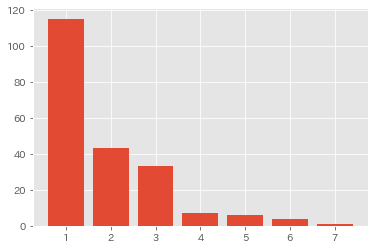

In [76]:
df_tmp = df_cus_riyo.groupby(["coupon_name"]).count().reset_index()
# sns.displot(df_cus_riyo["coupon_name"])
plt.bar(df_tmp["coupon_name"],df_tmp["customercd"])

In [77]:
df_tmp["riyo_maisu"] = df_tmp["coupon_name"] * df_tmp["customercd"]
df_tmp["ratio"] = round(df_tmp["riyo_maisu"] / df_tmp["riyo_maisu"].sum() * 100, 1)
df_tmp

,coupon_name,customercd,riyo_maisu,ratio
0,1,115,115,29.6
1,2,43,86,22.1
2,3,33,99,25.4
3,4,7,28,7.2
4,5,6,30,7.7
5,6,4,24,6.2
6,7,1,7,1.8


### 生鮮クーポン対象外との比較

In [78]:
query = """
WITH base AS(
  SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_header` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  WHERE salesday BETWEEN "2023-03-19" AND "2023-06-18"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND posid.customercd <> "0"
 ),
-- 生鮮購入状況
seisen_tmp AS (
  SELECT 
    ym, customer_id, CAST(trial_fresh_fan AS INT64) AS trial_fresh_fan,
  ROW_NUMBER() OVER(PARTITION BY customer_id ORDER BY ym DESC) AS number
  FROM `inunaki.dws_cdp_0001.dws_customer_wide_tags`
  WHERE ym BETWEEN "2023-03-01" AND "2023-04-30"
),
seisen_data AS(
  SELECT DISTINCT customer_id, trial_fresh_fan
  FROM seisen_tmp
  WHERE number = 1
),
-- 期間中の対象者がわかった
-- taisho_id AS(
--   SELECT base.customercd, COALESCE(trial_fresh_fan, 0) AS trial_fresh_fan
--   FROM base
--   LEFT JOIN seisen_data
--   ON base.customercd = seisen_data.customer_id
--   WHERE COALESCE(trial_fresh_fan, 0) = 0
--   ),


-- 期間前に買っていないかどうかを確認する
taisho_data AS(
SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd, 1 AS flg
FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
ON posid.customercd = ii.customercd
LEFT JOIN `inunaki.dim_common_0001.dim_product` product
ON posid.jan = product.jan
WHERE salesday BETWEEN "2023-03-19" AND "2023-06-18"
AND storecd IN(8,57,67,157,158,282,472,473)
AND posid.jan IN(
'00000004522646813791',
'00000004571256310336',
'00000004901001397457',
'00000004902130344916',
'00000004902130390418',
'00000004902165000269')
AND  (divisionname = "惣菜" OR divisionname = "青果")
AND posid.customercd <> "0"
),
 -- 期間中に対象の商品を買っていない人たち（これが全体になる）
taisho_id AS(
  SELECT base.customercd, COALESCE(flg, 0) AS flg
  FROM base
  LEFT JOIN taisho_data
  ON base.customercd = taisho_data.customercd
  WHERE  COALESCE(flg, 0) = 0
),


-- 期間中に対象の商品を買った人
result AS(
  SELECT  DISTINCT COALESCE(customercd_new, posid.customercd) AS customercd, 1 AS kounyu_flg 
  FROM `inunaki.dwd_cdp_0001.dwd_cdp_idpos_detail` posid 
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_change_history` ii
  ON posid.customercd = ii.customercd
  LEFT JOIN `inunaki.dim_common_0001.dim_crm_customer_info` cus_info
  ON posid.customercd = cus_info.customercd
  -- 対象になっている顧客のみに絞る
  JOIN taisho_id
  ON posid.customercd = taisho_id.customercd
  WHERE salesday BETWEEN "2023-06-19" AND "2023-07-13"
  AND storecd IN(8,57,67,157,158,282,472,473)
  AND jan IN(
 '00000002529579000000',
 '00000002556230000000',
 '00000004528594090000',
 '00000004580495200568')
)
-- 購入したかしていないかを見る
SELECT md5_cus.customercd, COALESCE(kounyu_flg, 0) AS kounyu_flg
FROM taisho_id
LEFT JOIN result
ON taisho_id.customercd = result.customercd
JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
ON taisho_id.customercd = md5_cus.customercd_md5

"""

df_taishogai_seisen = client.query(query).to_dataframe()

In [79]:
df_taishogai_seisen["customercd"] = df_taishogai_seisen["customercd"].astype(int)
# 対象の顧客は外す
df_taishogai_seisen = df_taishogai_seisen.merge(df_kikakubetu_id.rename(columns={"user_id":"customercd"}).query("kubun=='生鮮クーポン'"),on="customercd",how="left").fillna(0)
df_taishogai_seisen = df_taishogai_seisen.query("kubun==0")

In [80]:
df_taishogai_seisen["kubun"].unique()

array([0], dtype=object)

In [81]:
print("時短商品を対象外の同じ条件の人が期間中買った割合")
print(round(df_taishogai_seisen["kounyu_flg"].sum() / len(df_taishogai_seisen)*100,1),"%")

時短商品を対象外の同じ条件の人が期間中買った割合
13.5 %


In [82]:
# 対象外の人と比べるとどれくらい使われているか？
df_yes_coupon = df_kikakubetu_result.query("対象企画=='生鮮クーポン'")[["対象ID","クーポン利用UU","クーポン利用率"]]
df_yes_coupon = df_yes_coupon.rename(columns={"クーポン利用UU":"利用人数","クーポン利用率":"利用率"})
df_yes_coupon["区分"] = "対象"

df_no_coupon = pd.DataFrame({"区分":["対象外"],"対象ID":[df_taishogai_seisen["customercd"].nunique()],"利用人数":[df_taishogai_seisen["kounyu_flg"].sum()]})
df_no_coupon["利用率"] = round(df_no_coupon["利用人数"] / df_no_coupon["対象ID"] * 100,1)
df_no_coupon["利用率"] = df_no_coupon["利用率"].astype(str) + "%"

df_seisen_result = pd.concat([df_no_coupon,df_yes_coupon])
df_seisen_result.reindex(index=[5,0]).rename(columns={"利用人数":"購入人数","利用率":"購入率"})

,区分,対象ID,購入人数,購入率
5,対象,12488,105,0.98%
0,対象外,175409,23735,13.5%


In [83]:
df_jan2 = df_jan.merge(df_taisho_id.query("kubun=='生鮮クーポン'")[["jan2"]],on="jan2")
df_jan2["customercd"] = df_jan2["customercd"].astype(int)
df_jan2.merge(df_kikakubetu_id.query("kubun=='生鮮クーポン'").rename(columns={"user_id":"customercd"}),on="customercd")["customercd"].nunique()

1645

In [84]:
df_jan2.merge(df_kikakubetu_id.query("kubun=='生鮮クーポン'").rename(columns={"user_id":"customercd"}),on="customercd")

,salesday,customercd,jan,sales_amt,cnt,janname,jan2,customercd2,file,kubun
0,2023-07-07,2970002899842,00000002529579000000,299,1,桜島どりジャンボチキンカツ,2529579000000,2970002899842,生鮮クーポン,生鮮クーポン
1,2023-07-06,2970002899842,00000002556230000000,272,1,２段仕込旨み醤油から揚げ 中,2556230000000,2970002899842,生鮮クーポン,生鮮クーポン
2,2023-07-04,2970006229096,00000002529579000000,598,2,桜島どりジャンボチキンカツ,2529579000000,2970006229096,生鮮クーポン,生鮮クーポン
3,2023-06-25,2970006229096,00000002529579000000,299,1,桜島どりジャンボチキンカツ,2529579000000,2970006229096,生鮮クーポン,生鮮クーポン
4,2023-07-11,2970006229096,00000002529579000000,598,2,桜島どりジャンボチキンカツ,2529579000000,2970006229096,生鮮クーポン,生鮮クーポン
...,...,...,...,...,...,...,...,...,...,...
2637,2023-06-22,2970005547054,00000004580495200568,99,1,ＴＲＩＡＬミックスサラダ,4580495200568,2970005547054,生鮮クーポン,生鮮クーポン
2638,2023-06-28,2970003638242,00000004580495200568,69,1,ＴＲＩＡＬミックスサラダ,4580495200568,2970003638242,生鮮クーポン,生鮮クーポン
2639,2023-07-06,2970001689529,00000004580495200568,198,2,ＴＲＩＡＬミックスサラダ,4580495200568,2970001689529,生鮮クーポン,生鮮クーポン
2640,2023-06-24,2970002582355,00000004580495200568,198,2,ＴＲＩＡＬミックスサラダ,4580495200568,2970002582355,生鮮クーポン,生鮮クーポン


In [85]:
# ホームを見た人
query = """
SELECT sync_dttm, DATE(year, month, dt) AS dt, customercd, view_name
FROM `inunaki.dwd_action_0001.dwd_karte_supay_accesshome` view_data 
JOIN `inunaki.dim_crm_0001.dim_crm_customer_md5` md5_cus
ON view_data.customer_id = md5_cus.customercd_md5
WHERE DATE(year, month, dt) BETWEEN "2023-03-06" AND "2023-07-13"
"""

df_home_view2 = client.query(query).to_dataframe()
df_home_view2["salesday"] = pd.to_datetime(df_home_view2["dt"])
df_home_view2["salesday"] = pd.to_datetime(df_home_view2["salesday"])
df_home_view2 = df_home_view2.rename(columns={"customercd":"user_id"})
df_home_view2 = df_home_view2.merge(df_taisho2,on="user_id")

In [86]:
# 期間ごとの結果に変える
df_tmp3 = df_home_view2.query("salesday>=20230306&salesday<=20230331")
df_tmp4 = df_home_view2.query("salesday>=20230401&salesday<=20230430")
df_tmp6 = df_home_view2.query("salesday>=20230619&salesday<=20230713")
# ひとりあたりどれくらい開いてる？
df_tmp3 = df_tmp3.groupby(["user_id"]).count()["view_name"].reset_index()
df_tmp4 = df_tmp4.groupby(["user_id"]).count()["view_name"].reset_index()
df_tmp6 = df_tmp6.groupby(["user_id"]).count()["view_name"].reset_index()

In [87]:
# display(df_tmp3.describe())
# display(df_tmp4.describe())
# display(df_tmp6.describe())

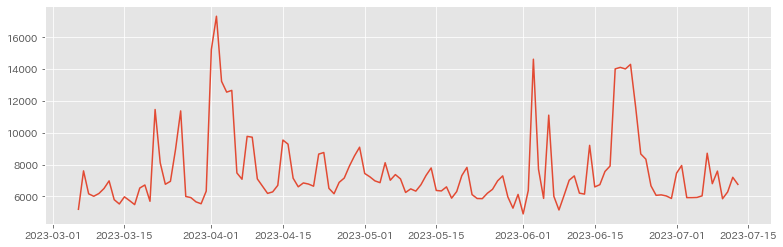

In [88]:
df_tmp = df_home_view2.groupby(["salesday"]).count()
df_tmp = df_tmp["user_id"]
plt.figure(figsize=(13,4))
plt.plot(df_tmp)

### クーポンごとの数値間について

In [97]:
# df_tmp = df_cupon_sengen.groupby(["coupon_name"]).agg({"user_id":"count"}).rename(columns={"user_id":"宣言数"}).reset_index()
# df_tmp2 = df_cupon_base.groupby(["coupon_name"]).agg({"flg":"count"}).rename(columns={"flg":"クーポン利用数"}).reset_index()
# df_item_jiku = df_tmp.merge(df_tmp2,on="coupon_name",how="outer")
# df_item_jiku = df_item_jiku.merge(df_taisho_id[["coupon_name","kubun"]].drop_duplicates(),on="coupon_name",how="right").fillna(0)
# df_item_jiku = df_item_jiku[["coupon_name","kubun","宣言数","クーポン利用数"]].sort_values("クーポン利用数",ascending=False)

In [140]:
df_cp_result = df_item_jiku.merge(df_kikakubetu_result[["対象企画","対象ID","アクティブユーザー","クーポンタブ閲覧UU"]].rename(columns={"対象企画":"kubun"}),on="kubun",how="left")
df_cp_result = df_cp_result[["coupon_name","kubun","対象ID","アクティブユーザー","クーポンタブ閲覧UU","宣言数","クーポン利用数"]]

df_cp_result["閲覧率"] = round(df_cp_result["クーポンタブ閲覧UU"] / df_cp_result["アクティブユーザー"]*100, 1)
df_cp_result["閲覧率"] = df_cp_result["閲覧率"].astype(str) + "%"
df_cp_result["宣言率"] = round(df_cp_result["宣言数"] / df_cp_result["アクティブユーザー"]*100, 2)
df_cp_result["宣言率"] = df_cp_result["宣言率"].astype(str) + "%"
df_cp_result["利用率"] = round(df_cp_result["クーポン利用数"] / df_cp_result["アクティブユーザー"]*100, 2)
df_cp_result["利用率"] = df_cp_result["利用率"].astype(str) + "%"

In [144]:
df_cp_result.to_csv("6月のクーポン結果.csv",index=False,encoding="utf_8_sig")